# Keras model for Posture Detection

## Defining transformers  

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
#from category_encoders.one_hot import OneHotEncoder
#from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Imputer
#from category_encoders.ordinal import OrdinalEncoder
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import warnings
warnings.filterwarnings("ignore")
import ipytest.magics
import pytest
# set the file name (required)
__file__ = 'drone_pos_model.ipynb'

In [8]:
class Shuffler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        x=x.loc[np.random.permutation(x.index)]
        
        return x
############################################################################################
class XCentralizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, x_columns):
        self.x_columns = x_columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shift=x[["rightShoulder_x","leftShoulder_x","leftHip_x","rightHip_x"]].sum(axis=1)/4
        for col in self.x_columns:
            x[col] = x[col] - shift
        return x
############################################################################################
    
class YCentralizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, y_columns):
        self.y_columns = y_columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shift=x[["rightShoulder_y","leftShoulder_y","leftHip_y","rightHip_y"]].sum(axis=1)/4
        for col in list(set(self.y_columns)-set(["label"])):
            x[col] = x[col] - shift
        return x
############################################################################################

class YScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shoulder_y = x[["rightShoulder_y","leftShoulder_y"]].sum(axis=1)/2
        hip_y = x[["leftHip_y","rightHip_y"]].sum(axis=1)/2
        y_dist = hip_y - shoulder_y
        
        for col in list(set(x.columns)-set(["label"])):
            x[col] /= y_dist
        return x

## Data inspecting

In [9]:
#!pwd
#df = pd.read_csv("video_001.csv", delimiter=',')
# Christian's video is less noisy. Therefore I only train the model with his data at the moment. 
# acc increased 5 % taking his video camparing to all videos.
#path = "all_videos_posture_steptime50_checksum8160"
#path = "video_Christian_posture_steptime50_checksum8160"
path = "video_all_posture_steptime50_checksum8160"
df = pd.read_csv("../data/"+ path + ".csv",low_memory=False)
#df=df.drop([5557], axis=0)
#type(df.leftShoulder_x)
#df.info()
#print(df.dtypes)
#print()
print('labels: \n', df['label'].unique())
# we have a mix of categorical, numeric, and string data.
df.head(3)

labels: 
 [1 3 4 2 0]


,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftElbow_x,leftElbow_y,rightElbow_x,rightElbow_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
0,0.49250,0.18750,0.4000,0.18250,0.5050,0.26000,0.34375,0.19500,0.50875,0.33875,0.26625,0.16875,0.46500,0.34375,0.41125,0.34625,1
1,0.49250,0.18875,0.4025,0.18625,0.5075,0.25875,0.33250,0.19750,0.50000,0.33750,0.27625,0.17500,0.46750,0.33625,0.40875,0.33750,1
2,0.49125,0.19000,0.4025,0.17875,0.5050,0.26125,0.33500,0.19875,0.51125,0.33500,0.26375,0.16875,0.46375,0.33875,0.40875,0.33750,1


## Data cleaning

In [10]:
df1=df.dropna().drop_duplicates()
df1.shape

(3719, 17)

In [11]:
# Checking that we don't have any null values
assert df1.isnull().all().all() == False

## Non-pipline steps

In [16]:
x=df1.copy()
features_df = x.drop("label", axis=1)
label_df = x["label"]


In [17]:

from sklearn.model_selection import train_test_split
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(features_df, label_df, test_size=0.2, random_state=10)

In [18]:
x_train_df.shape, x_test_df.shape, y_train_df.shape, y_test_df.shape 

((2975, 16), (744, 16), (2975,), (744,))

In [19]:
x=df1.copy()
#x=x.drop(["label"], axis = 1)
x_cols = ['leftShoulder_x', 'rightShoulder_x',
        'leftElbow_x', 'rightElbow_x',
        'leftWrist_x', 'rightWrist_x',
        'leftHip_x', 'rightHip_x']
#xtrans = XCentralizer(x_cols)
#x = xtrans.transform(x)

y_cols = list(set(x.columns)-set(x_cols))
#print(y_cols)
#ytrans = YCentralizer(y_cols)
#x = ytrans.transform(x)

#ytrans = YScaler()
#x = ytrans.transform(x)
x[:2]

,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftElbow_x,leftElbow_y,rightElbow_x,rightElbow_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
0,0.4925,0.18750,0.4000,0.18250,0.5050,0.26000,0.34375,0.1950,0.50875,0.33875,0.26625,0.16875,0.4650,0.34375,0.41125,0.34625,1
1,0.4925,0.18875,0.4025,0.18625,0.5075,0.25875,0.33250,0.1975,0.50000,0.33750,0.27625,0.17500,0.4675,0.33625,0.40875,0.33750,1


In [20]:
from sklearn.pipeline import make_pipeline, make_union

processing_pipeline = make_pipeline(
    XCentralizer(x_cols),
    YCentralizer(y_cols), 
    YScaler(),
    Shuffler()
    )

In [21]:
processed_df = processing_pipeline.fit_transform(x)

In [22]:
features_df = processed_df.drop("label", axis=1)
label_df = processed_df["label"]

In [23]:
%%run_pytest[clean]
def test_processingpipeline():
    # remember, this first pipeline only acts on the features, not the target.
    processed_df = processing_pipeline.fit_transform(x)
    
    # check for data leakage
    assert x.shape[0] == processed_df.shape[0]

============================================================================= test session starts =============================================================================
platform darwin -- Python 3.6.5, pytest-3.5.1, py-1.5.3, pluggy-0.6.0
rootdir: /Users/lsafari/drone_steering/models, inifile:
plugins: remotedata-0.2.1, openfiles-0.3.0, doctestplus-0.1.3, arraydiff-0.2
collected 1 item

drone_pos_model.py .                                                                                                                                                    [100%]

========================================================================== 1 passed in 0.03 seconds ===========================================================================


In [24]:
df_train = processed_df.iloc[:int(processed_df.shape[0]*0.8)]
df_val = processed_df.iloc[int(processed_df.shape[0]*0.8):]

In [25]:
assert df_train.shape[0] + df_val.shape[0] == processed_df.shape[0]

In [26]:
y_train_df = df_train['label']
x_train_df = df_train.drop('label', axis = 1)
y_val_df = df_val['label']
x_val_df = df_val.drop('label', axis = 1)
x_train=x_train_df.values
y_train=y_train_df.values
x_val=x_val_df.values
y_val=y_val_df.values

In [27]:
x_train
print("x_train=", x_train[0],"\n y_train=", y_train[0])

x_train= [ 0.31054687 -0.47265625 -0.28320312 -0.52734375  0.39648438  0.01171875
 -0.39257812 -0.02734375  0.39648438  0.50390625 -0.43164062  0.39453125
  0.19335938  0.53515625 -0.22070312  0.46484375] 
 y_train= 4


In [28]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

Using TensorFlow backend.


In [29]:
print(y_train[0])
print(y_val[0])

[0. 0. 0. 0. 1.]
[0. 1. 0. 0. 0.]


# Training Model

In [30]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from math import sqrt
import matplotlib.pyplot as plt

# Model Architecture

In [31]:
from keras import models, layers
from keras.models import Model
from keras.layers import Input, Dense
from keras import optimizers, losses, metrics


#default vaues
#activation="relu"
#optimizer="adam"
lr=0.01
#momentum=0
#creat model
model = models.Sequential()
model.add(layers.Dense(
        20, 
        activation="relu", 
        input_shape=(16, )))
model.add(layers.Dense(15, activation="relu"))
model.add(layers.Dense(5, activation="softmax")) #is a fast rectifier
model.summary()   

model.compile(
optimizer=optimizers.RMSprop(lr=0.01),
loss=losses.categorical_crossentropy,
metrics=["accuracy"] 
)
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                340       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 80        
Total params: 735
Trainable params: 735
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(x_train, y_train, epochs=1000, batch_size=30)

Epoch 1/1000
2975/2975 [==============================] - 0s 88us/step - loss: 1.1163 - acc: 0.5859
Epoch 2/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.8038 - acc: 0.7509
Epoch 3/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.7069 - acc: 0.7751
Epoch 4/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.6252 - acc: 0.8118
Epoch 5/1000
2975/2975 [==============================] - 0s 42us/step - loss: 0.5734 - acc: 0.8252
Epoch 6/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.5474 - acc: 0.8339
Epoch 7/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.5024 - acc: 0.8450
Epoch 8/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.4997 - acc: 0.8491
Epoch 9/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.4831 - acc: 0.8471
Epoch 10/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.4673 - acc: 0.8575

2975/2975 [==============================] - 0s 41us/step - loss: 0.2547 - acc: 0.9183
Epoch 83/1000
2975/2975 [==============================] - 0s 42us/step - loss: 0.2644 - acc: 0.9170
Epoch 84/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.2618 - acc: 0.9200
Epoch 85/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2575 - acc: 0.9187
Epoch 86/1000
2975/2975 [==============================] - 0s 42us/step - loss: 0.2628 - acc: 0.9163
Epoch 87/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.2646 - acc: 0.9197
Epoch 88/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.2635 - acc: 0.9207
Epoch 89/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.2598 - acc: 0.9183
Epoch 90/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2576 - acc: 0.9193
Epoch 91/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.2509 - acc: 0.9160
Epoc

2975/2975 [==============================] - 0s 40us/step - loss: 0.2380 - acc: 0.9244
Epoch 163/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.2267 - acc: 0.9297
Epoch 164/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2392 - acc: 0.9281
Epoch 165/1000
2975/2975 [==============================] - 0s 41us/step - loss: 0.2293 - acc: 0.9321
Epoch 166/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.2285 - acc: 0.9264
Epoch 167/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.2223 - acc: 0.9281
Epoch 168/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2340 - acc: 0.9304
Epoch 169/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.2476 - acc: 0.9304
Epoch 170/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.2216 - acc: 0.9334
Epoch 171/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2361 - acc: 0.

2975/2975 [==============================] - 0s 42us/step - loss: 0.2176 - acc: 0.9365
Epoch 243/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.2207 - acc: 0.9314
Epoch 244/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.2014 - acc: 0.9321
Epoch 245/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.2275 - acc: 0.9355
Epoch 246/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.2315 - acc: 0.9351
Epoch 247/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.2150 - acc: 0.9361
Epoch 248/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.2307 - acc: 0.9294
Epoch 249/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.2185 - acc: 0.9351
Epoch 250/1000
2975/2975 [==============================] - 0s 40us/step - loss: 0.2200 - acc: 0.9291
Epoch 251/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.2112 - acc: 0.

2975/2975 [==============================] - 0s 37us/step - loss: 0.2140 - acc: 0.9338
Epoch 323/1000
2975/2975 [==============================] - 0s 34us/step - loss: 0.2021 - acc: 0.9311
Epoch 324/1000
2975/2975 [==============================] - 0s 34us/step - loss: 0.2048 - acc: 0.9355
Epoch 325/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1908 - acc: 0.9368
Epoch 326/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.2262 - acc: 0.9331
Epoch 327/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.2008 - acc: 0.9371
Epoch 328/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.2081 - acc: 0.9361
Epoch 329/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1963 - acc: 0.9355
Epoch 330/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.2127 - acc: 0.9334
Epoch 331/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1972 - acc: 0.

2975/2975 [==============================] - 0s 41us/step - loss: 0.1971 - acc: 0.9382
Epoch 403/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.2015 - acc: 0.9334
Epoch 404/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.1962 - acc: 0.9358
Epoch 405/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1818 - acc: 0.9445
Epoch 406/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1951 - acc: 0.9418
Epoch 407/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.1957 - acc: 0.9392
Epoch 408/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.2003 - acc: 0.9392
Epoch 409/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1981 - acc: 0.9371
Epoch 410/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.2130 - acc: 0.9341
Epoch 411/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.2144 - acc: 0.

2975/2975 [==============================] - 0s 42us/step - loss: 0.2205 - acc: 0.9338
Epoch 483/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1936 - acc: 0.9398
Epoch 484/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1874 - acc: 0.9425
Epoch 485/1000
2975/2975 [==============================] - 0s 35us/step - loss: 0.1993 - acc: 0.9345
Epoch 486/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1932 - acc: 0.9455
Epoch 487/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.2035 - acc: 0.9308
Epoch 488/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.2019 - acc: 0.9361
Epoch 489/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1952 - acc: 0.9368
Epoch 490/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.2015 - acc: 0.9345
Epoch 491/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1934 - acc: 0.

2975/2975 [==============================] - 0s 40us/step - loss: 0.2381 - acc: 0.9412
Epoch 563/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.2004 - acc: 0.9328
Epoch 564/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1760 - acc: 0.9405
Epoch 565/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.2157 - acc: 0.9385
Epoch 566/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.1780 - acc: 0.9435
Epoch 567/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.2015 - acc: 0.9334
Epoch 568/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1824 - acc: 0.9398
Epoch 569/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1893 - acc: 0.9412
Epoch 570/1000
2975/2975 [==============================] - 0s 35us/step - loss: 0.1972 - acc: 0.9375
Epoch 571/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.1908 - acc: 0.

2975/2975 [==============================] - 0s 42us/step - loss: 0.1829 - acc: 0.9408
Epoch 643/1000
2975/2975 [==============================] - 0s 39us/step - loss: 0.1996 - acc: 0.9375
Epoch 644/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.1879 - acc: 0.9442
Epoch 645/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1830 - acc: 0.9398
Epoch 646/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.2031 - acc: 0.9365
Epoch 647/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1793 - acc: 0.9435
Epoch 648/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1774 - acc: 0.9395
Epoch 649/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1827 - acc: 0.9392
Epoch 650/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1753 - acc: 0.9449
Epoch 651/1000
2975/2975 [==============================] - 0s 66us/step - loss: 0.1823 - acc: 0.

2975/2975 [==============================] - 0s 39us/step - loss: 0.1833 - acc: 0.9429
Epoch 723/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1800 - acc: 0.9432
Epoch 724/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1722 - acc: 0.9422
Epoch 725/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1799 - acc: 0.9445
Epoch 726/1000
2975/2975 [==============================] - 0s 35us/step - loss: 0.2013 - acc: 0.9402
Epoch 727/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1825 - acc: 0.9439
Epoch 728/1000
2975/2975 [==============================] - 0s 35us/step - loss: 0.1718 - acc: 0.9439
Epoch 729/1000
2975/2975 [==============================] - 0s 35us/step - loss: 0.1686 - acc: 0.9418
Epoch 730/1000
2975/2975 [==============================] - 0s 35us/step - loss: 0.1804 - acc: 0.9452
Epoch 731/1000
2975/2975 [==============================] - 0s 35us/step - loss: 0.1959 - acc: 0.

2975/2975 [==============================] - 0s 39us/step - loss: 0.1903 - acc: 0.9402
Epoch 803/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1918 - acc: 0.9439
Epoch 804/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1639 - acc: 0.9496
Epoch 805/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.1677 - acc: 0.9429
Epoch 806/1000
2975/2975 [==============================] - 0s 38us/step - loss: 0.1839 - acc: 0.9445
Epoch 807/1000
2975/2975 [==============================] - 0s 35us/step - loss: 0.1833 - acc: 0.9439
Epoch 808/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1587 - acc: 0.9449
Epoch 809/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1907 - acc: 0.9398
Epoch 810/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1730 - acc: 0.9452
Epoch 811/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1822 - acc: 0.

2975/2975 [==============================] - 0s 35us/step - loss: 0.1628 - acc: 0.9449
Epoch 883/1000
2975/2975 [==============================] - 0s 34us/step - loss: 0.1653 - acc: 0.9472
Epoch 884/1000
2975/2975 [==============================] - 0s 34us/step - loss: 0.2048 - acc: 0.9392
Epoch 885/1000
2975/2975 [==============================] - 0s 34us/step - loss: 0.1874 - acc: 0.9422
Epoch 886/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1671 - acc: 0.9486
Epoch 887/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1740 - acc: 0.9466
Epoch 888/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1775 - acc: 0.9442
Epoch 889/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1966 - acc: 0.9395
Epoch 890/1000
2975/2975 [==============================] - 0s 35us/step - loss: 0.1883 - acc: 0.9398
Epoch 891/1000
2975/2975 [==============================] - 0s 34us/step - loss: 0.1867 - acc: 0.

2975/2975 [==============================] - 0s 38us/step - loss: 0.1920 - acc: 0.9432
Epoch 963/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1714 - acc: 0.9472
Epoch 964/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1738 - acc: 0.9445
Epoch 965/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.2000 - acc: 0.9442
Epoch 966/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1872 - acc: 0.9402
Epoch 967/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1885 - acc: 0.9432
Epoch 968/1000
2975/2975 [==============================] - 0s 36us/step - loss: 0.1875 - acc: 0.9472
Epoch 969/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1939 - acc: 0.9442
Epoch 970/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1932 - acc: 0.9385
Epoch 971/1000
2975/2975 [==============================] - 0s 37us/step - loss: 0.1925 - acc: 0.

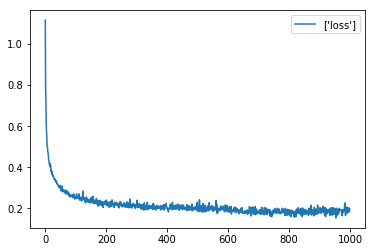

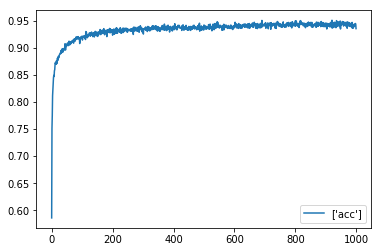

In [33]:

plt.plot(history.history["loss"], label=["loss"]) #play with hyperparameters to see the changes
plt.legend()
plt.show()
plt.close()

plt.plot(history.history["acc"],  label=["acc"])
plt.legend()
plt.show()
plt.close()



In [38]:
test_loss, test_acc = model.evaluate(x_val, y_val)
print("Loss / Accuracy Evaluation")
print("--------------------------")
print("Loss:     " + str(round(test_loss,5)))
print("Accuracy: " + str(round(test_acc,5)))

744/744 [==============================] - 0s 19us/step
Loss / Accuracy Evaluation
--------------------------
Loss:     0.33298
Accuracy: 0.91667


In [39]:
val_y_pred = model.predict(x_val)

In [40]:
val_y_pred[10]

array([1.9140657e-07, 2.1038881e-02, 3.8363163e-05, 4.0604462e-08,
       9.7892249e-01], dtype=float32)

In [41]:
y_val[10]

array([0., 0., 0., 0., 1.], dtype=float32)

### Save Model in tensorflow.js Format

The tensorflowjs library can't be installed directly with pip / conda due to conflicting dependencies. Best is to set up a new environment explicitly for this and install tensorflowjs with the following commands:

```
pip install tensorflow==1.11.0rc2 h5py numpy keras
pip install --no-deps tensorflowjs
```

In [37]:
! pip install tensorflow==1.11.0rc2 h5py numpy keras
! pip install --no-deps tensorflowjs

  Could not find a version that satisfies the requirement tensorflow==1.11.0rc2 (from versions: 0.12.1, 1.0.0, 1.1.0rc0, 1.1.0rc1, 1.1.0rc2, 1.1.0, 1.2.0rc0, 1.2.0rc1, 1.2.0rc2, 1.2.0, 1.2.1, 1.3.0rc0, 1.3.0rc1, 1.3.0rc2, 1.3.0, 1.4.0rc0, 1.4.0rc1, 1.4.0, 1.4.1, 1.5.0rc0, 1.5.0rc1, 1.5.0, 1.5.1, 1.6.0rc0, 1.6.0rc1, 1.6.0, 1.7.0rc0, 1.7.0rc1, 1.7.0, 1.7.1, 1.8.0rc0, 1.8.0rc1, 1.8.0, 1.9.0rc0, 1.9.0rc1, 1.9.0rc2, 1.9.0, 1.10.0rc0, 1.10.0rc1, 1.10.0, 1.10.1, 1.11.0rc0, 1.11.0, 1.12.0rc0, 1.12.0rc1, 1.12.0rc2)
No matching distribution found for tensorflow==1.11.0rc2


In [35]:

! pip install --upgrade pip

    100% |████████████████████████████████| 1.3MB 3.5MB/s ta 0:00:01
  Found existing installation: pip 18.0
    Uninstalling pip-18.0:
      Successfully uninstalled pip-18.0


In [36]:
! pip install ipykernel
! pip install tensorflow_hub

In [38]:
import tensorflowjs as tfjs

In [46]:
! pwd

/Users/lsafari/drone_steering/models


In [54]:
from keras.models import load_model
import h5py

model.save('pose_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

In [ ]:
model.save("/")

In [53]:
tfjs.converters.save_keras_model(model, 'model_pose_tfjs')

We need to adapt the two files as follows in order for them to work on Azure:
* add a file extension .pb to the file with no extension (otherwise Azure blocks it from viewing)
* adapt the automatically generated model.json to reflect the extension .pb